In [1412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1413]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [1414]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


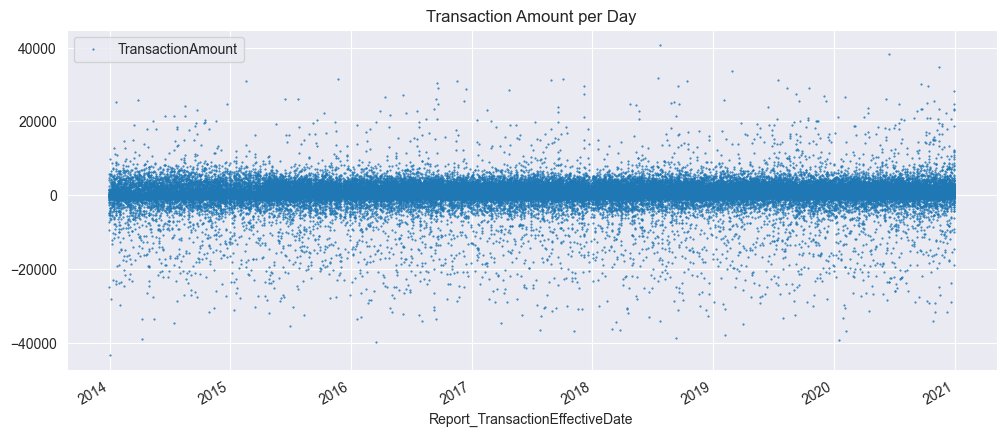

In [1415]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [1416]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('B').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-25,1613.384621
2020-12-28,1613.384621
2020-12-29,82156.304473


In [1417]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 83


In [1418]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

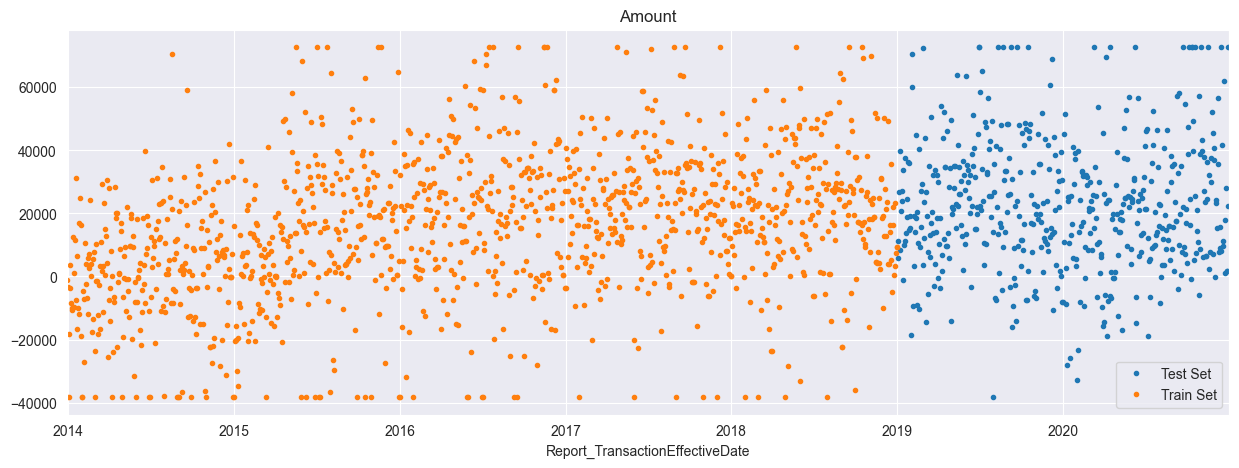

In [1419]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [1420]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [1421]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,37164.647769,10.523140
1,2013-12-31,-38240.561498,1.000000,0.693147
2,2014-01-01,-3465.890925,34775.670573,10.456702
3,2014-01-02,-38240.561498,1.000000,0.693147
4,2014-01-03,-18386.381900,19855.179598,9.896271
...,...,...,...,...
1302,2018-12-26,3319.146441,41560.707939,10.634935
1303,2018-12-27,23269.148943,61510.710441,11.026983
1304,2018-12-28,7577.044740,45818.606238,10.732467
1305,2018-12-31,9481.245786,47722.807284,10.773186


In [1422]:
%%time
model = Prophet(
    seasonality_prior_scale=15,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,  
    changepoint_prior_scale=0.1,  
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=12) 
model.add_seasonality(name='weekly', period=7, fourier_order=18)  
model.add_seasonality(name='yearly', period=365.25, fourier_order=25)

model.fit(data_train_prophet)

22:47:58 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 15.6 ms
Wall time: 174 ms


In [1423]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-02,10.969252,5.927345,10.257489,10.969252,10.969252,-2.836578,-2.836578,-2.836578,-2.011466,...,-0.205434,-0.205434,-0.205434,-0.619678,-0.619678,-0.619678,0.0,0.0,0.0,8.132674
1,2019-01-03,10.969443,7.294601,11.606680,10.969443,10.969443,-1.587579,-1.587579,-1.587579,-0.796774,...,-0.203664,-0.203664,-0.203664,-0.587141,-0.587141,-0.587141,0.0,0.0,0.0,9.381864
2,2019-01-04,10.969634,7.594139,11.852118,10.969634,10.969634,-1.131091,-1.131091,-1.131091,-0.246714,...,-0.337980,-0.337980,-0.337980,-0.546396,-0.546396,-0.546396,0.0,0.0,0.0,9.838543
3,2019-01-07,10.970206,8.736201,13.048956,10.970206,10.970206,-0.131665,-0.131665,-0.131665,0.058503,...,0.196532,0.196532,0.196532,-0.386700,-0.386700,-0.386700,0.0,0.0,0.0,10.838541
4,2019-01-08,10.970397,8.643618,13.083605,10.970397,10.970397,-0.136002,-0.136002,-0.136002,0.225235,...,-0.035650,-0.035650,-0.035650,-0.325587,-0.325587,-0.325587,0.0,0.0,0.0,10.834396


In [1424]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.969252,5.927345,10.257489,10.969252,10.969252,-2.836578,-2.836578,-2.836578,-2.011466,...,-0.205434,-0.205434,-0.619678,-0.619678,-0.619678,0.0,0.0,0.0,8.132674,-34837.672653
1,2019-01-03,10.969443,7.294601,11.606680,10.969443,10.969443,-1.587579,-1.587579,-1.587579,-0.796774,...,-0.203664,-0.203664,-0.587141,-0.587141,-0.587141,0.0,0.0,0.0,9.381864,-26370.444769
2,2019-01-04,10.969634,7.594139,11.852118,10.969634,10.969634,-1.131091,-1.131091,-1.131091,-0.246714,...,-0.337980,-0.337980,-0.546396,-0.546396,-0.546396,0.0,0.0,0.0,9.838543,-19499.182235
3,2019-01-07,10.970206,8.736201,13.048956,10.970206,10.970206,-0.131665,-0.131665,-0.131665,0.058503,...,0.196532,0.196532,-0.386700,-0.386700,-0.386700,0.0,0.0,0.0,10.838541,12705.449811
4,2019-01-08,10.970397,8.643618,13.083605,10.970397,10.970397,-0.136002,-0.136002,-0.136002,0.225235,...,-0.035650,-0.035650,-0.325587,-0.325587,-0.325587,0.0,0.0,0.0,10.834396,12494.672215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2020-12-25,11.107321,8.531140,12.782744,11.038965,11.174190,-0.473462,-0.473462,-0.473462,0.412492,...,-0.337980,-0.337980,-0.547974,-0.547974,-0.547974,0.0,0.0,0.0,10.633859,3275.466059
518,2020-12-28,11.107894,8.862640,13.095602,11.039367,11.174890,-0.098373,-0.098373,-0.098373,0.350474,...,0.196532,0.196532,-0.645379,-0.645379,-0.645379,0.0,0.0,0.0,11.009521,22205.336833
519,2020-12-29,11.108084,8.526070,12.917710,11.039387,11.175182,-0.366951,-0.366951,-0.366951,0.326478,...,-0.035650,-0.035650,-0.657778,-0.657778,-0.657778,0.0,0.0,0.0,10.741134,7976.868837
520,2020-12-30,11.108275,7.982667,12.378991,11.039387,11.175473,-0.913062,-0.913062,-0.913062,-0.047952,...,-0.205434,-0.205434,-0.659675,-0.659675,-0.659675,0.0,0.0,0.0,10.195214,-11466.838982


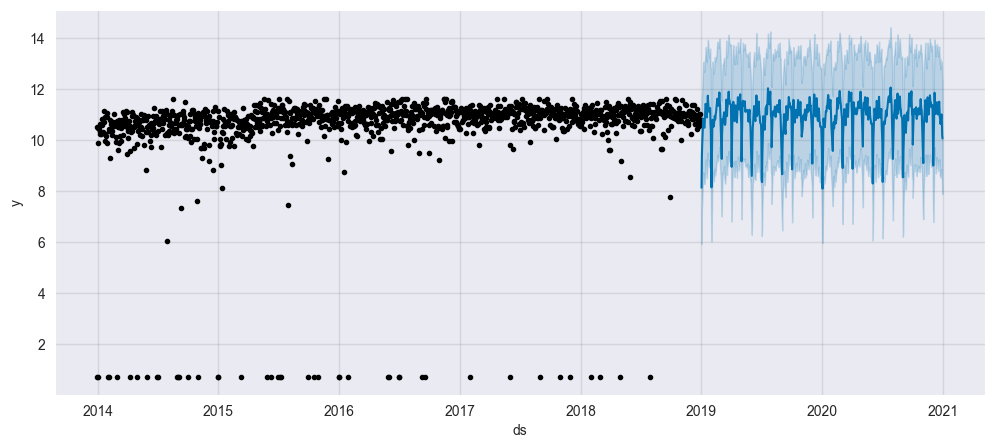

In [1425]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [1426]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,49327.546871,10.806258
2019-01-03,5997.282482,44238.843980,10.697381
2019-01-04,26741.238955,64982.800452,11.081893
2019-01-07,39674.677746,77916.239244,11.263403
2019-01-08,8270.261060,46511.822558,10.747483
...,...,...,...
2020-12-25,1613.384621,39854.946119,10.593027
2020-12-28,1613.384621,39854.946119,10.593027
2020-12-29,72710.241069,110951.802567,11.616860


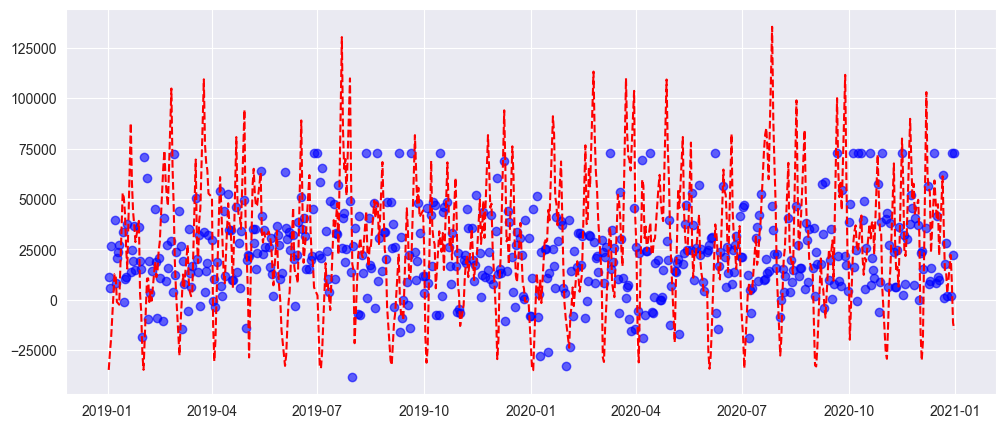

In [1427]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [1428]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2019-01-02,10.969252,5.927345,10.257489,10.969252,10.969252,-2.836578,-2.836578,-2.836578,-2.011466,...,-0.205434,-0.205434,-0.619678,-0.619678,-0.619678,0.0,0.0,0.0,8.132674,-34837.672653
1,2019-01-03,10.969443,7.294601,11.606680,10.969443,10.969443,-1.587579,-1.587579,-1.587579,-0.796774,...,-0.203664,-0.203664,-0.587141,-0.587141,-0.587141,0.0,0.0,0.0,9.381864,-26370.444769
2,2019-01-04,10.969634,7.594139,11.852118,10.969634,10.969634,-1.131091,-1.131091,-1.131091,-0.246714,...,-0.337980,-0.337980,-0.546396,-0.546396,-0.546396,0.0,0.0,0.0,9.838543,-19499.182235
3,2019-01-07,10.970206,8.736201,13.048956,10.970206,10.970206,-0.131665,-0.131665,-0.131665,0.058503,...,0.196532,0.196532,-0.386700,-0.386700,-0.386700,0.0,0.0,0.0,10.838541,12705.449811
4,2019-01-08,10.970397,8.643618,13.083605,10.970397,10.970397,-0.136002,-0.136002,-0.136002,0.225235,...,-0.035650,-0.035650,-0.325587,-0.325587,-0.325587,0.0,0.0,0.0,10.834396,12494.672215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2020-12-25,11.107321,8.531140,12.782744,11.038965,11.174190,-0.473462,-0.473462,-0.473462,0.412492,...,-0.337980,-0.337980,-0.547974,-0.547974,-0.547974,0.0,0.0,0.0,10.633859,3275.466059
518,2020-12-28,11.107894,8.862640,13.095602,11.039367,11.174890,-0.098373,-0.098373,-0.098373,0.350474,...,0.196532,0.196532,-0.645379,-0.645379,-0.645379,0.0,0.0,0.0,11.009521,22205.336833
519,2020-12-29,11.108084,8.526070,12.917710,11.039387,11.175182,-0.366951,-0.366951,-0.366951,0.326478,...,-0.035650,-0.035650,-0.657778,-0.657778,-0.657778,0.0,0.0,0.0,10.741134,7976.868837
520,2020-12-30,11.108275,7.982667,12.378991,11.039387,11.175473,-0.913062,-0.913062,-0.913062,-0.047952,...,-0.205434,-0.205434,-0.659675,-0.659675,-0.659675,0.0,0.0,0.0,10.195214,-11466.838982


In [1429]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,49327.546871,10.806258
2019-01-03,5997.282482,44238.843980,10.697381
2019-01-04,26741.238955,64982.800452,11.081893
2019-01-07,39674.677746,77916.239244,11.263403
2019-01-08,8270.261060,46511.822558,10.747483
...,...,...,...
2020-12-25,1613.384621,39854.946119,10.593027
2020-12-28,1613.384621,39854.946119,10.593027
2020-12-29,72710.241069,110951.802567,11.616860


In [1430]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

36384.08587690216

In [1431]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

28458.10765418723

In [1432]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

423.51006677150593

In [1433]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [1434]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,11.108657,7.306868,11.933275,11.108657,11.108657,-1.532045,-1.532045,-1.532045,-0.561489,...,-0.337980,-0.337980,-0.337980,-0.632576,-0.632576,-0.632576,0.0,0.0,0.0,9.576612
1,2021-01-02,11.108848,6.733890,11.075579,11.108848,11.108848,-2.251349,-2.251349,-2.251349,-1.939951,...,0.293098,0.293098,0.293098,-0.604497,-0.604497,-0.604497,0.0,0.0,0.0,8.857499
2,2021-01-03,11.109039,6.636335,10.930296,11.109039,11.109039,-2.286097,-2.286097,-2.286097,-2.011466,...,0.293098,0.293098,0.293098,-0.567730,-0.567730,-0.567730,0.0,0.0,0.0,8.822942
3,2021-01-04,11.109230,7.759978,12.219562,11.109230,11.109230,-1.123524,-1.123524,-1.123524,-0.796774,...,0.196532,0.196532,0.196532,-0.523283,-0.523283,-0.523283,0.0,0.0,0.0,9.985706
4,2021-01-05,11.109421,8.132704,12.492264,11.109421,11.109421,-0.754706,-0.754706,-0.754706,-0.246714,...,-0.035650,-0.035650,-0.035650,-0.472341,-0.472341,-0.472341,0.0,0.0,0.0,10.354716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,11.124890,9.845330,14.418574,11.123169,11.126997,1.052865,1.052865,1.052865,0.392708,...,0.293098,0.293098,0.293098,0.367059,0.367059,0.367059,0.0,0.0,0.0,12.177755
86,2021-03-28,11.125081,9.989282,14.455953,11.123309,11.127241,1.133413,1.133413,1.133413,0.443787,...,0.293098,0.293098,0.293098,0.396528,0.396528,0.396528,0.0,0.0,0.0,12.258493
87,2021-03-29,11.125272,10.069345,14.339993,11.123458,11.127493,0.990988,0.990988,0.990988,0.374963,...,0.196532,0.196532,0.196532,0.419493,0.419493,0.419493,0.0,0.0,0.0,12.116260
88,2021-03-30,11.125462,9.652678,14.055314,11.123614,11.127750,0.760855,0.760855,0.760855,0.361184,...,-0.035650,-0.035650,-0.035650,0.435321,0.435321,0.435321,0.0,0.0,0.0,11.886318


In [1435]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,yhat_original
0,2021-01-01,11.108657,7.306868,11.933275,11.108657,11.108657,-1.532045,-1.532045,-1.532045,-0.561489,...,-0.337980,-0.337980,-0.632576,-0.632576,-0.632576,0.0,0.0,0.0,9.576612,-23818.085774
1,2021-01-02,11.108848,6.733890,11.075579,11.108848,11.108848,-2.251349,-2.251349,-2.251349,-1.939951,...,0.293098,0.293098,-0.604497,-0.604497,-0.604497,0.0,0.0,0.0,8.857499,-31214.675613
2,2021-01-03,11.109039,6.636335,10.930296,11.109039,11.109039,-2.286097,-2.286097,-2.286097,-2.011466,...,0.293098,0.293098,-0.567730,-0.567730,-0.567730,0.0,0.0,0.0,8.822942,-31453.354955
3,2021-01-04,11.109230,7.759978,12.219562,11.109230,11.109230,-1.123524,-1.123524,-1.123524,-0.796774,...,0.196532,0.196532,-0.523283,-0.523283,-0.523283,0.0,0.0,0.0,9.985706,-16527.703690
4,2021-01-05,11.109421,8.132704,12.492264,11.109421,11.109421,-0.754706,-0.754706,-0.754706,-0.246714,...,-0.035650,-0.035650,-0.472341,-0.472341,-0.472341,0.0,0.0,0.0,10.354716,-6836.777506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,11.124890,9.845330,14.418574,11.123169,11.126997,1.052865,1.052865,1.052865,0.392708,...,0.293098,0.293098,0.367059,0.367059,0.367059,0.0,0.0,0.0,12.177755,156174.329521
86,2021-03-28,11.125081,9.989282,14.455953,11.123309,11.127241,1.133413,1.133413,1.133413,0.443787,...,0.293098,0.293098,0.396528,0.396528,0.396528,0.0,0.0,0.0,12.258493,172522.213770
87,2021-03-29,11.125272,10.069345,14.339993,11.123458,11.127493,0.990988,0.990988,0.990988,0.374963,...,0.196532,0.196532,0.419493,0.419493,0.419493,0.0,0.0,0.0,12.116260,144578.835243
88,2021-03-30,11.125462,9.652678,14.055314,11.123614,11.127750,0.760855,0.760855,0.760855,0.361184,...,-0.035650,-0.035650,0.435321,0.435321,0.435321,0.0,0.0,0.0,11.886318,107023.820114


In [1436]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -23818.09
1  Precision Analyst  2021-01-02             -31214.68
2  Precision Analyst  2021-01-03             -31453.35
3  Precision Analyst  2021-01-04             -16527.70
4  Precision Analyst  2021-01-05              -6836.78
